In [1]:
# import all packages
import pandas as pd 
import numpy as np 
import textwrap 

import seaborn as sns 
import matplotlib.pyplot as plt 

import shap 

from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 

from sklearn.model_selection import KFold, cross_validate, cross_val_predict, RepeatedKFold, cross_val_score, GridSearchCV 
from sklearn.metrics import r2_score, mean_absolute_error 

import statsmodels.api as sm

/Users/etiennechenevert/opt/anaconda3/envs/qwasd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id='_SHAP'></a>
## SHAP Analysis

SHapley Additive exPlanations, SHAP, is a python package to explain how your model makes predictions after training. This is called *post hoc explainability* by Roscher et al 2020. The analysis that I present will show how to use some basic functions in the package to gather feature importance and feature dependence plots. However, there is a variety of other types of analysis one could do, depending on the model, that are described in the docs: https://shap.readthedocs.io/en/latest/

## SHAP on the Bayesian Ridge Regression

To get a basic understanding of what the Shapely values are and how to use them, I will give some explanations using the Bayesian Ridge, linear regression model. I do this because we already know how a linear regression model will approximate the output variable and can witness how shapely values are able to capture our expectations.

Shapely values are an explanation technique acquired from game theory that seek to quantify the involvement of players in a game. While this is an abstract notion, our use case defines the “players” as the features in the GPR model, and the “game” as the task of predicting vertical accretion rates. 

The direct computation of individual shapely values can be extremely computationally expensive. This is due to each individual shapely value quantifying the contribution of single sample of a single feature within a group of many features on the target variable. To do this, we include and exclude a feature from every possible set of the features that comprise the GPR model we defined. For instance, let this feature be the $j^{th}$ feature. We then randomly sample a value from each feature of the subset, compute the estimated outcome including the random sample of the $j^{th}$ feature, compute the estimated outcome excluding the $j^{th}$ feature, then subtract the two estimations from each other. The difference is the shapely value, making the shapely value the average contribution of a feature across all possible subsets of features. This can be thought of mathematically below (Molnar 2019, Štrumbelj and Kononenko 2014):
$$\phi_j=\frac{1}{M} \sum_{m=1}^{M} \hat{f}(x)_{-j}^m - \hat{f}(x)_{+j}^m$$
Equation 9

Where $\hat{f}(x)_{-j}^m$ is excluding the feature of interest, the $j^{th}$ feature, for the $m^th$ subset and $\hat{f}(x)_{+j}^m$ is including the feature of interest for the m^th subset. In our case the Shapely values will be in terms of influence on vertical accretion rate mm/yr. To overcome the computational expense of this process, an appropriate approximation method, such as a Monte-Carlo sampling method, is often employed to optimize the computation (Štrumbelj and Kononenko 2014).

Below, we show a bar plot of feature importances computed from shapely values. the importance scores are determined by averaging the absolute shapely values per feature across the data such that (Molnar 2019):

$$ Importance_j = \frac{1}{N} \sum_{n = 1}^{N} |\phi_j^n|$$
Equation 10

Where $Importance_i$ indicates the importance of the $j^{th}$ feature, $\phi_j^n$ indicates the shapely value of the $i^{th}$ sample of the $j^{th}$ feature, and $N$ indicates the total number of samples.

<class 'pandas.core.frame.DataFrame'>


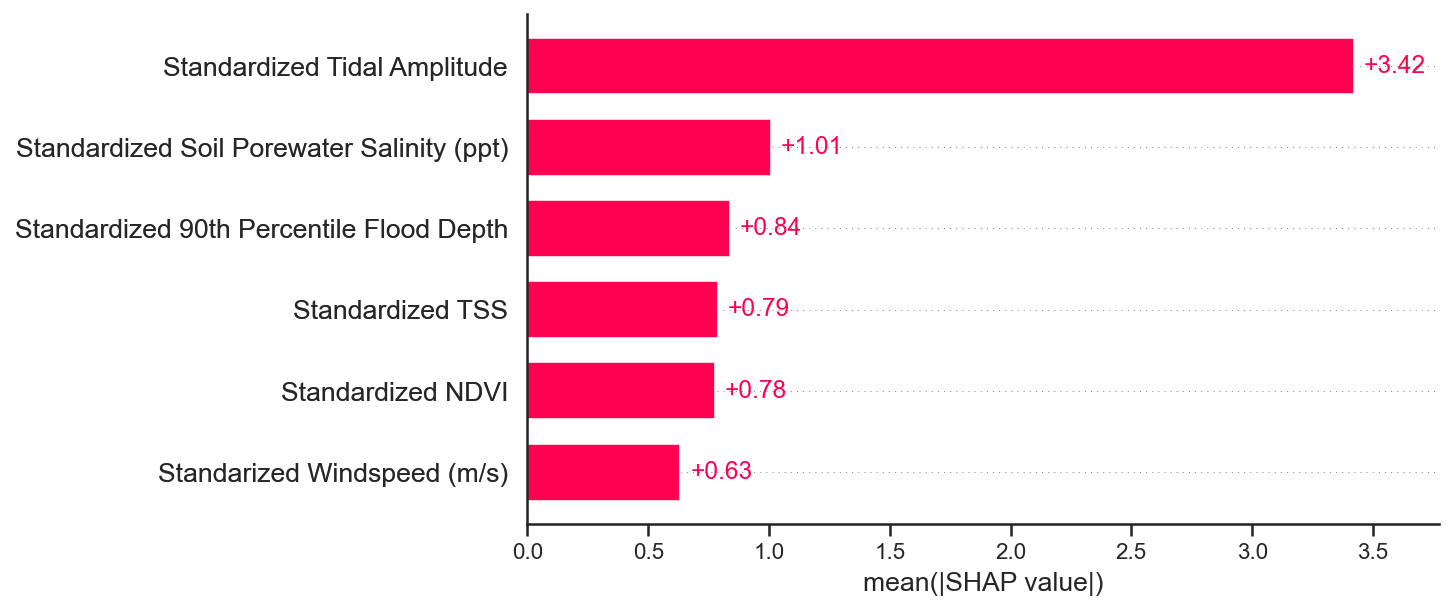

In [22]:
# Make a dataframe specifically for shap
shap_df = data[bestfeatures]
# include "standardized" in the feature names to make it clear that these features are standardized/scaled
shap_df = shap_df.rename(columns={'Tidal Amplitude (cm)': 'Standardized Tidal Amplitude',
                                 'Avg. Flood Depth (cm)':'Standardized Avg. Flood Depth',
                                 '90th Percentile Flood Depth (cm)': 'Standardized 90th Percentile Flood Depth',
                                 'Soil Porewater Salinity (ppt)': 'Standardized Soil Porewater Salinity (ppt)', 
                                 'NDVI': 'Standardized NDVI', 
                                 'TSS (mg/l)': 'Standardized TSS', 
                                 'Avg. Time Flooded (%)': 'Standardized Avg. Time Flooded',
                                 '10th Percentile Flood Depth (cm)': 'Standardized 10th Percentile Flood Depth',
                                 'Windspeed (m/s)': 'Standarized Windspeed (m/s)'}
                        )

# fit the model first
br.fit(shap_df, target)
# Shap Analysis
X500 = shap.utils.sample(shap_df, 500) # randomly sample 100 instances for use as the background distribution
print(type(X500))
explainer_ebm = shap.Explainer(br.predict, X500)  # explain a random sample of the data
# explainer = shap.Explainer(gp)
shap_values_ebm = explainer_ebm(X500)

shap.plots.bar(shap_values_ebm)

We see that the feature importances computed by the SHAP values are almost the same as our computed feature importances values using only the mean of the learned weight vectors, given scaled predictor variables. 

We can visualize a more informative representation of the feature importances using the summary plot method from SHAP. This plot gives us the order of feature importances, the distribution of shapely values, and an idea of the direction of influence each feature has on the outcome. Similar to the above bar plot, the feature importances are in descending order. From where the points are located horizontally, to the right or left of the SHAP value equals 0 (x-axis), we can determine whether that points holds positive or negative influence on the outcome. If the distribution of the shapely values widens, this means more shapely values lie in that range. Depending on whether the widening lies to the left or right of the $0$ on the x-axis, we can determine whether the majority of samples hold a positive or negative influence on accretion. The colorbar on the right of plot indicates the specific feature's importance value for that given sample. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


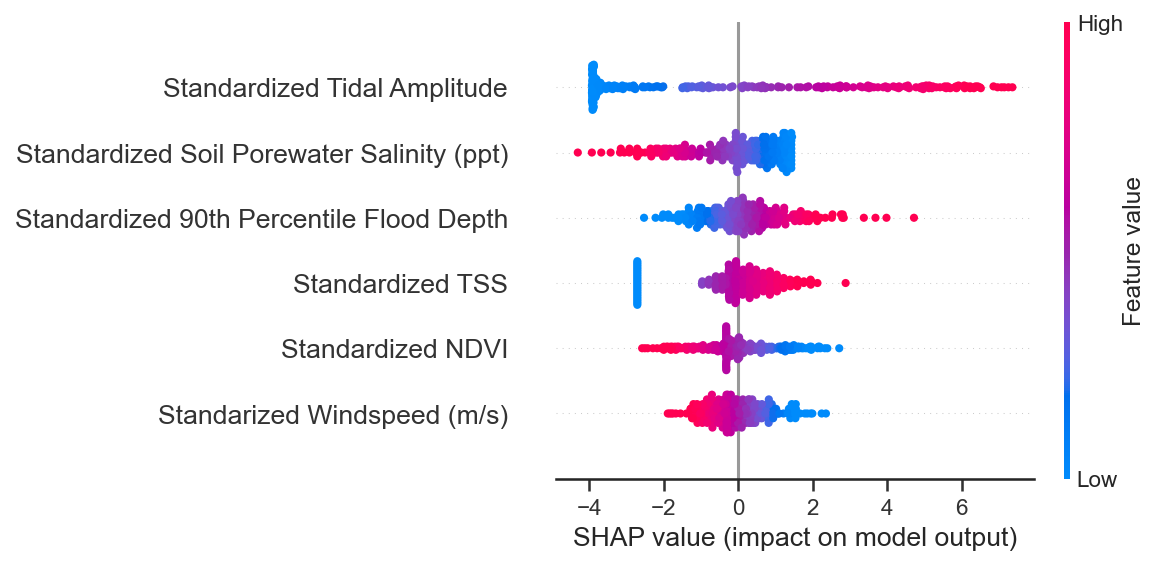

In [23]:
shap.summary_plot(shap_values_ebm, features=shap_df, feature_names=shap_df.columns.values)

Examining the three most important features in the summary plot, we see that tidal amplitude has a net positive affect on the outcome as indicated by the red colorbar, while a substantial amount of the samples in the distribution are contributing negatively to accretion rate. Average flood depth also has a net positive effect on vertical accretion rate, while, again, much of the samples contribute negatively to vertical accretion rate. Opposite to tidal amplitude and average flood depth, soil porewater salinity contributes negatively to vertical accretion rate, while much of the samples actually contribute positively!

Another way to interpret how certain features and samples are influencing our predicted vertical accretion rates is through a *heatmap* plot. The heatmap highlights how each sample influences certain predictions. On the upper x-axis (top of plot) we see how the outcome, $f(x)$, varies given different samples. For this particular plot, I have arranged the instances so that the expected vertical accretion values is decreasing from left to right. In our case, $f(x)$ is vertical accretion rate. The red segments indicate a positive shapely value for the feature corresponding horizontally, indicating that the feature positively influences the expected vertical accretion rate. While the blue segments indicate negative shapely values, indicating that the corresponding feature negatively influences the expected vertical accretion rate.

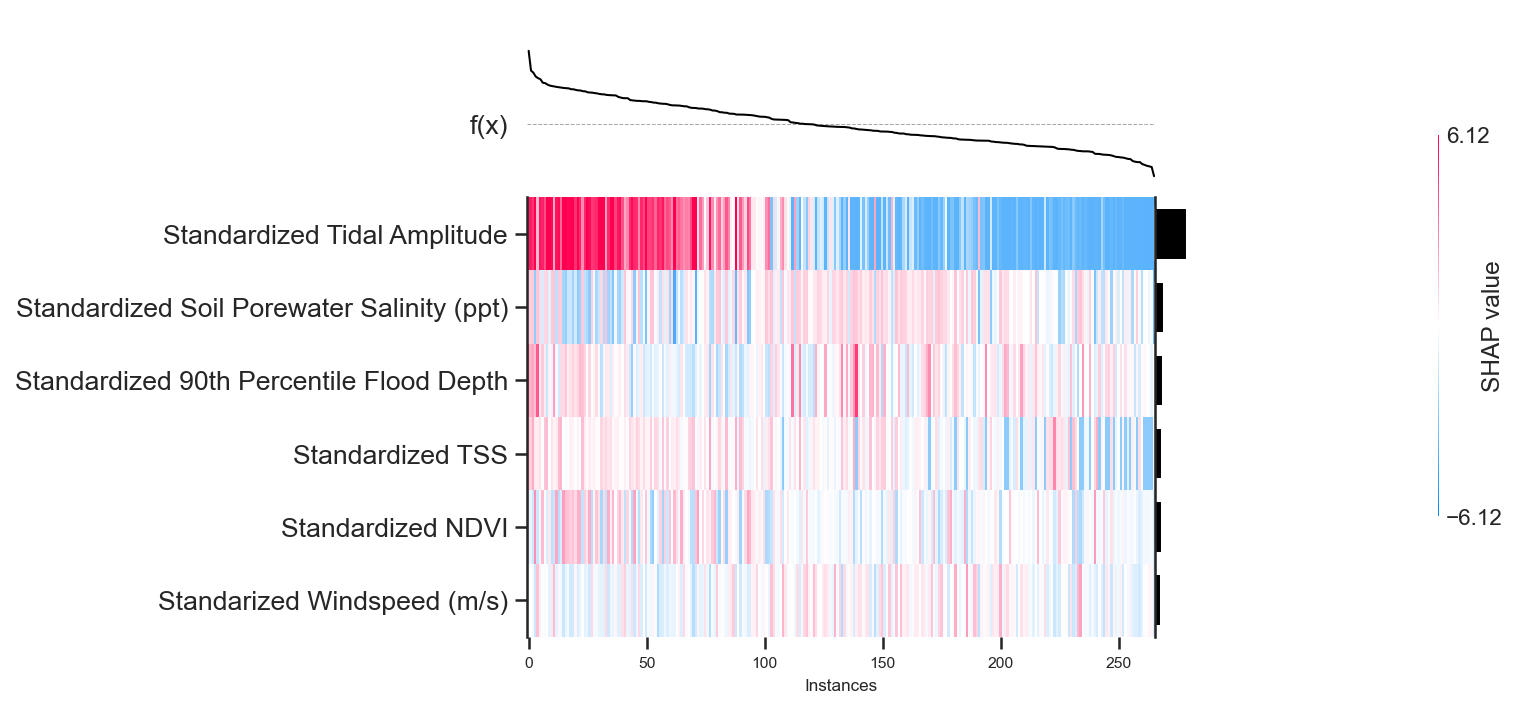

In [24]:
# A summary of the sample scale predictions
shap.plots.heatmap(shap_values_ebm, instance_order=shap_values_ebm.sum(1))

Through the heatmap, we see that tidal amplitude is largely the determinant variable for predicted accretion rates. Most of tidal amplitude's positive shapely values lie to the left of the plot, where $f(x)$ is positive, while most of the negative shapely values lie to the right where $f(x)$ is negative.


## Partial Dependence Plots and SHAP Dependence Plots

Partial dependence plots are show the marginal effect of a feature and the resultant outcome variable given our model (Molnar 2019), helping us get an idea of the type of relationship the two variables have together. Given that we are looking at the partial dependence plots within a linear regression, we will expect to see only linear relationships in these plots between outcome and feature. The $E[f(x)]$ is the mean of the outcome we want to approximate, vertical accretion rate. While $E["variable-name"]$ is the mean of the distribution of the variable represented in the plot.

The SHAP dependence plots are similar, but slightly different to the partial dependence plots. Rather than the expected outcome on the y-axis, the shapely value is represented. While the partial dependence plot will roughly approximate the trends of the SHAP dependence plots. We also color the SHAP dependence plots by the magnitude of a related variable to the variable shown on the x-axis to understand interactions between variables. Red indicates higher value of the interacting variable, while bluw represents a lower value of the interacting variable.

Let us examine the partial dependence plots for the 3 main contributors to accretion. 

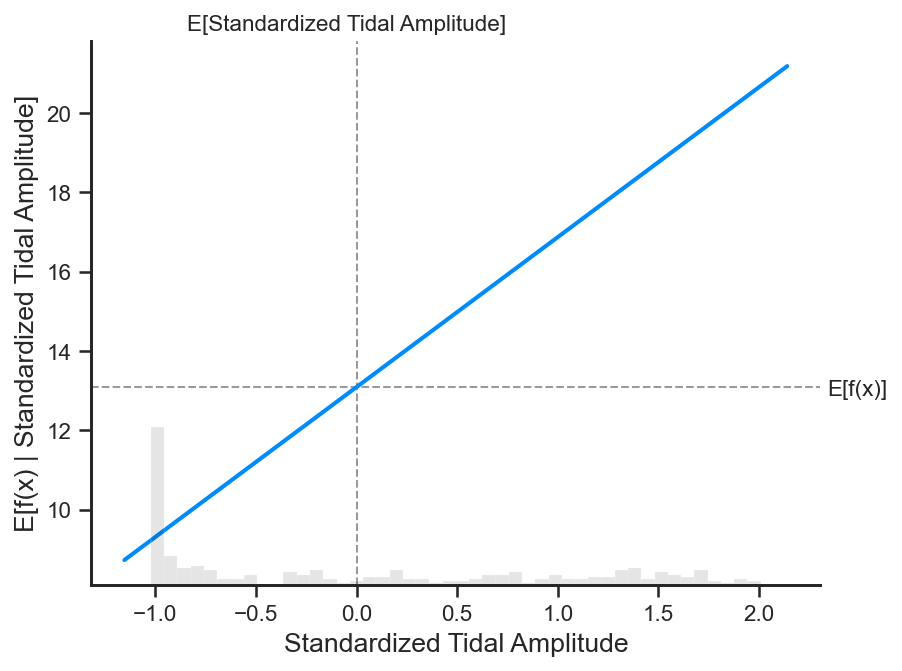

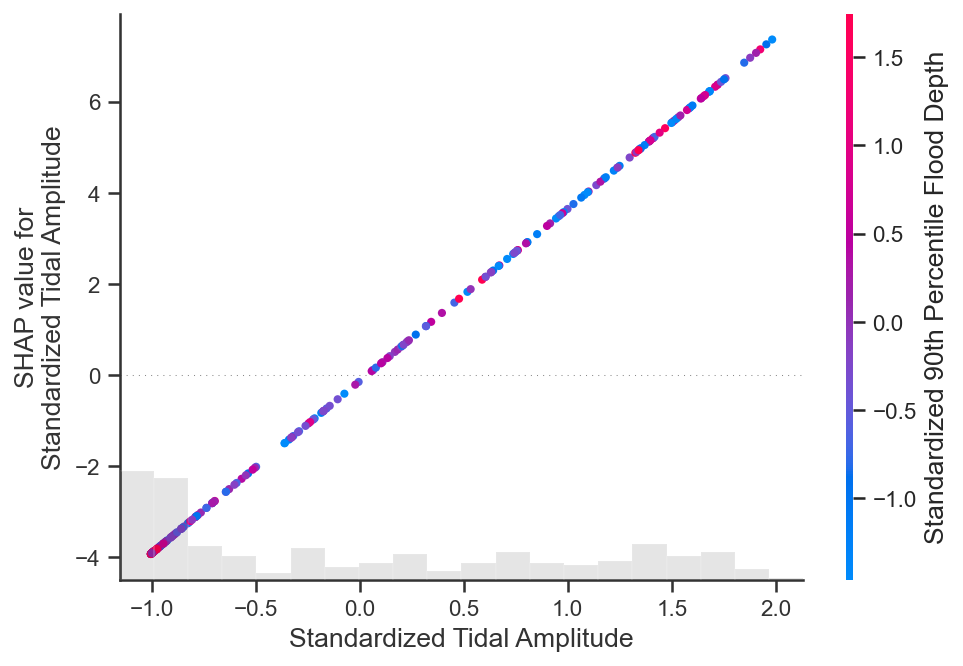

In [25]:
shap.partial_dependence_plot(
    'Standardized Tidal Amplitude', br.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot
shap.plots.scatter(shap_values_ebm[:, "Standardized Tidal Amplitude"],
                   color=shap_values_ebm[:,"Standardized 90th Percentile Flood Depth"])

Tidal amplitude has a clear positive relationship with the expected vertical accretion outcome as depicted by the partial dependence plot. The SHAP dependence plots displays a similar story, while the samples are colored by the normalized average flood depth value. However, there is no clear relationship between certain average flood depth values and increasing or decreasing expected outcomes.

Next we are going to investigate the average flood depth, the second most important variable in our BLR model. But, we must also take a lot at the 90th percentile of the flood depth along with the average flood depth because the two are inherently intertwined. As flood depth increases, we expect the 90th percentile of the flood depth to increase as well. The below scatter plot reinforces this notion.

We can vaguely see the different signatures of the influence of the 90th percentile flood depth at varying tidal amplitudes in the above scatter plot. For the same 90th percentile flood depth of, for example 40 cm, there is significantly less vertical accretion at a tidal amplitude of 0 cm versus at a tidal amplitude of 25 cm. This is what our model is picking up as shown by the SHAP dependence plot.

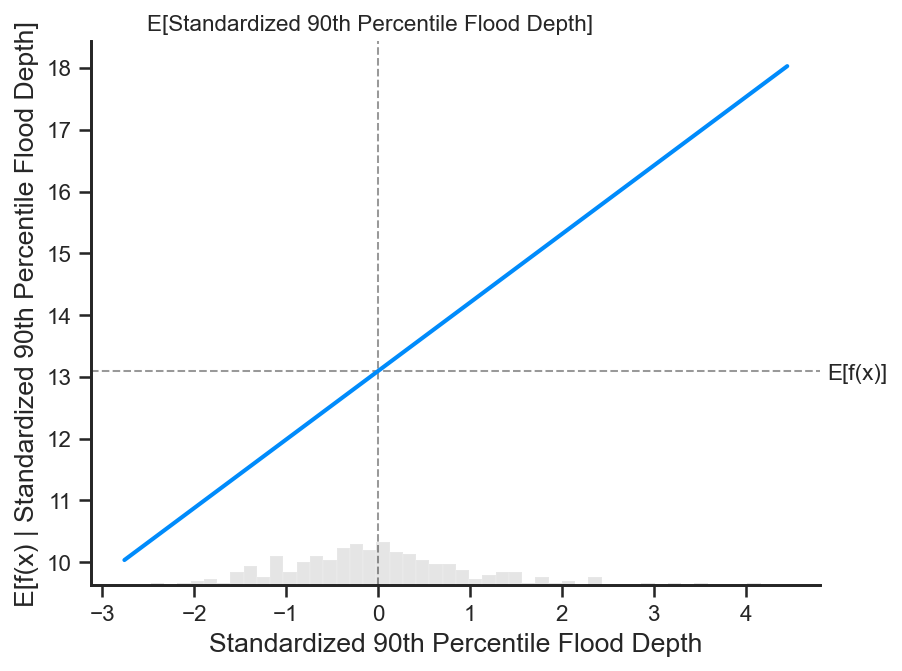

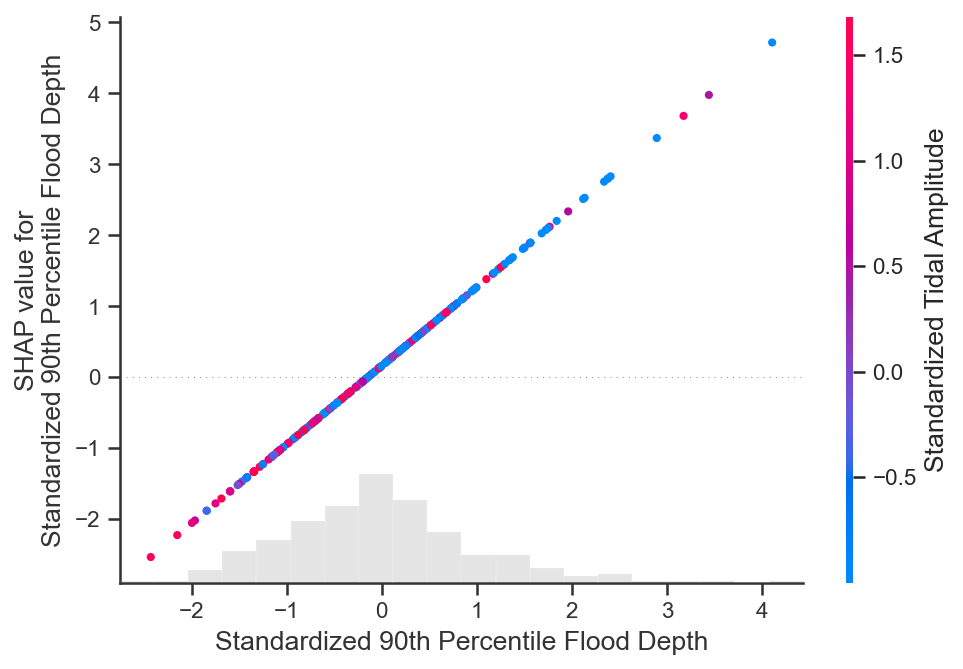

In [26]:
# Let us look at the partial dependence plot for Avgerage flood depth
shap.partial_dependence_plot(
    "Standardized 90th Percentile Flood Depth", br.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the SHAP dependence plot for average flood depth
shap.plots.scatter(shap_values_ebm[:, "Standardized 90th Percentile Flood Depth"],
                   color=shap_values_ebm[:,"Standardized Tidal Amplitude"])

## SHAP Analysis for Gaussian Process Regression

To visualize the nonlinear dynamics captured by the Gaussian Process Regression, we will implement the same SHAP analysis as we did for the Bayesian Linear Regression. Notice that the form kernel function will largely dictate the type of functions that will be represented between the features and vertical accretion rate. 

<class 'pandas.core.frame.DataFrame'>


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


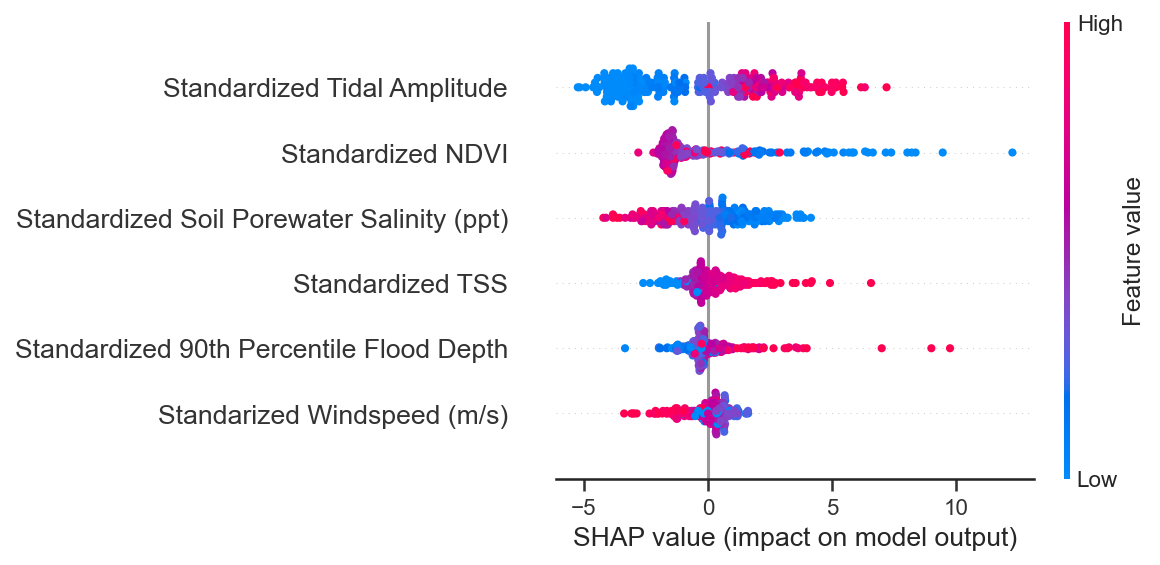

In [28]:
# fit the model first
gp.fit(shap_df, target)
# Shap Analysis
X500 = shap.utils.sample(shap_df, 500) # randomly sample 100 instances for use as the background distribution
print(type(X500))
explainer_ebm = shap.Explainer(gp.predict, X500)  # explain a random sample of the data
# explainer = shap.Explainer(gp)
shap_values_ebm = explainer_ebm(shap_df)

shap.summary_plot(shap_values_ebm, features=shap_df, feature_names=shap_df.columns.values)

While average flood depth and tidal amplitude are still identified as the most important variables, the importance of the other variables changes slightly in the GPR model. Let's look at the heatmap summary plot to get a better idea of how these variables influence different accretion rates.

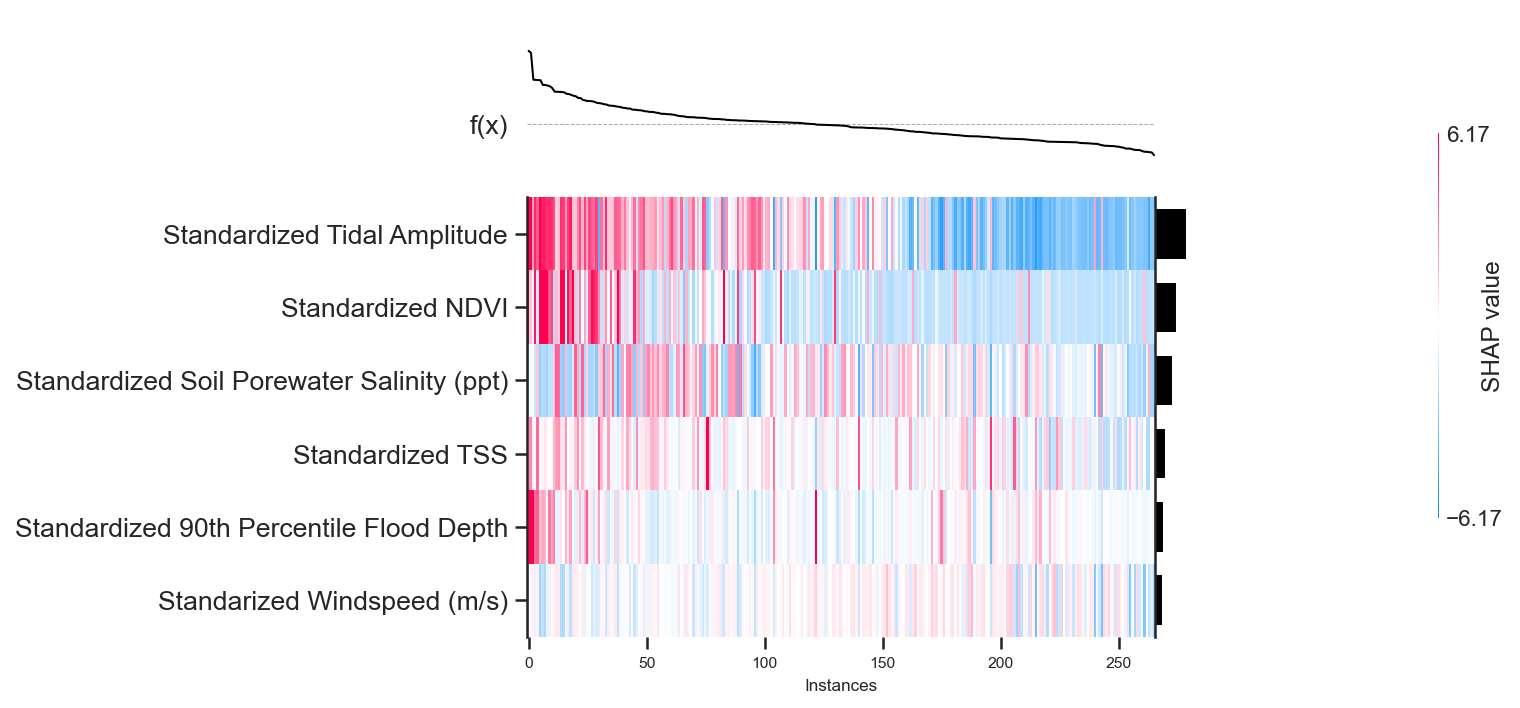

In [29]:
# A summary of the sample scale predictions
shap.plots.heatmap(shap_values_ebm, instance_order=shap_values_ebm.sum(1))

Similar trends as in the BLR are picked up, except there is definitely less of a reliance on tidal amplitude for making vertical accretion rate predictions. We also see that the higher estimates of vertical accretion rates are largely positively influenced by tidal amplitude, NDVI, and the 90th percentile of flood depth. While the lowest estimates of vertical accretion are largely negatively influenced by tidal amplitude and NDVI, but rely little upon the 90th percentile of flood depth. 

Let's again look at some partial dependence and SHAP dependence plots to see how the GPR differs from the BLR.

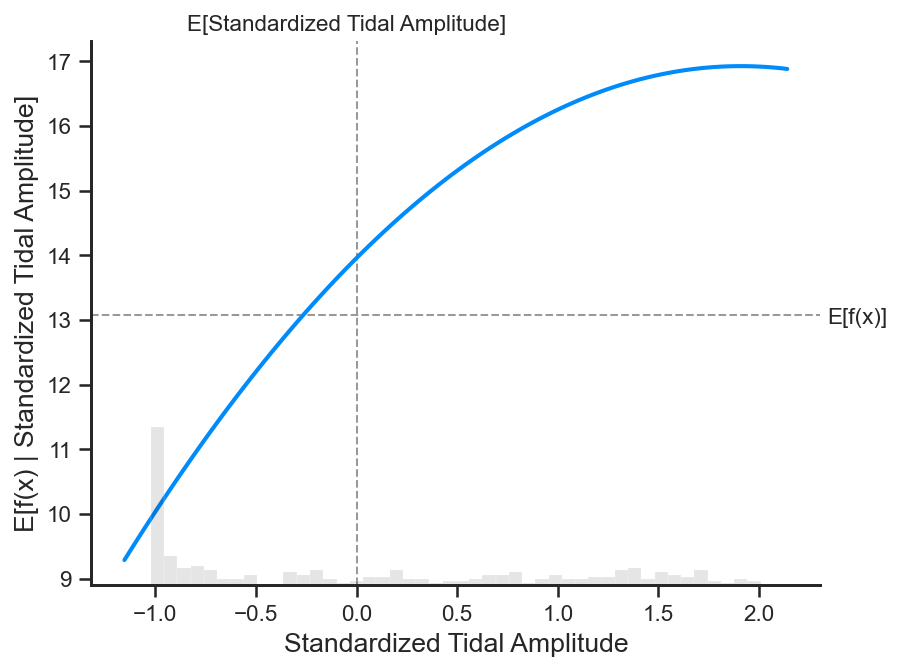

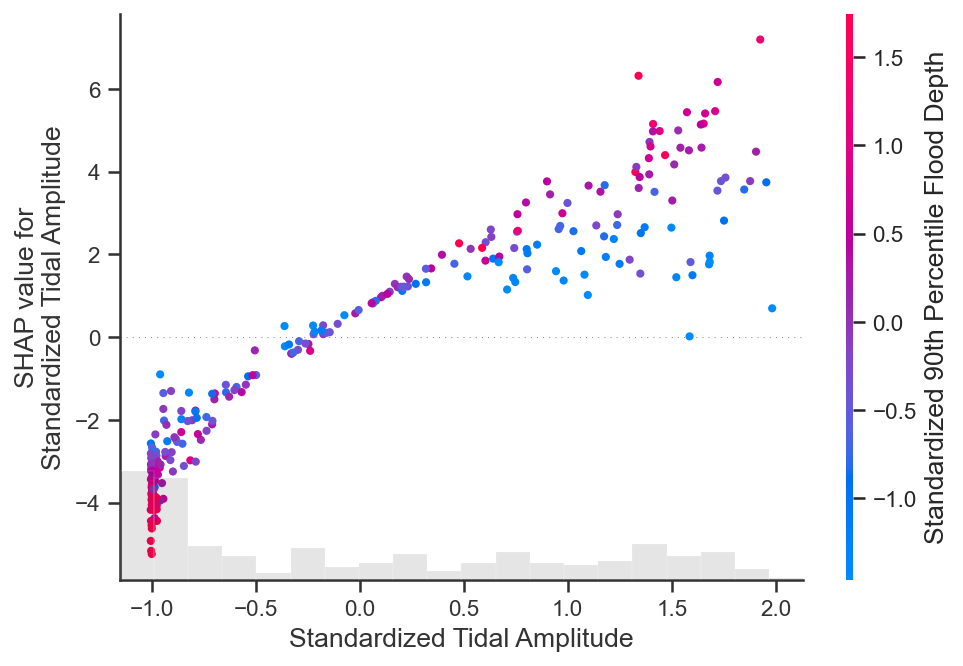

In [30]:
# Plot the partial dependence of the tidal amplitude within the GPR
shap.partial_dependence_plot(
    'Standardized Tidal Amplitude', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Lets also check out the dependence plot of tidal amplitude within the GPR, colored by average flood depth
shap.plots.scatter(shap_values_ebm[:, "Standardized Tidal Amplitude"],
                   color=shap_values_ebm[:,"Standardized 90th Percentile Flood Depth"])

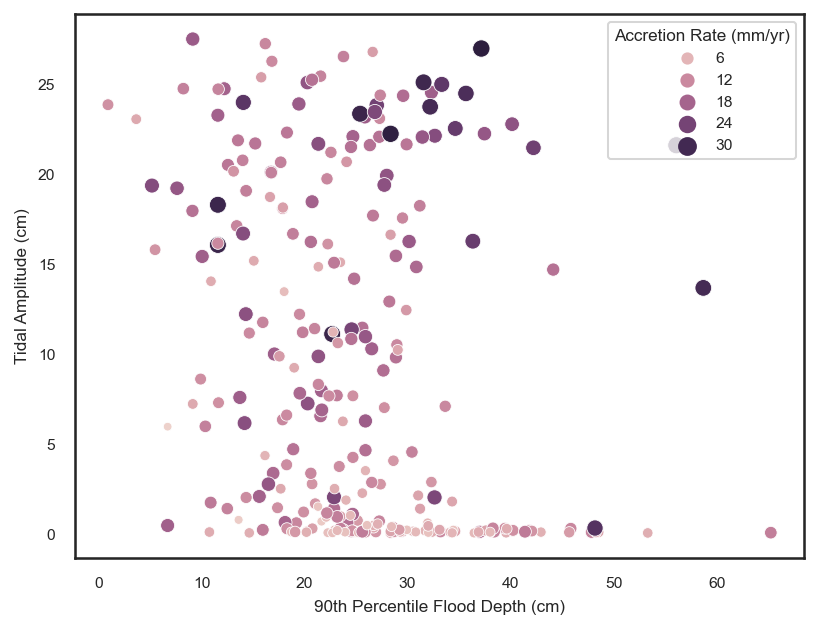

In [31]:
sns.scatterplot(data=df, x='90th Percentile Flood Depth (cm)', y='Tidal Amplitude (cm)', hue='Accretion Rate (mm/yr)',
               size='Accretion Rate (mm/yr)')
plt.show()

Nice! We get a similar trend as in the partial dependence plot for the BLR, but, this time, there is a little curvature to the partial dependence function. This indicates that the trend between tidal amplitude and accretion is truly captured with a linear relationship. We see a slight nonlinearity to this form, but its significance might be largely minimal. 

The zero in the x-axis indicates that mean of the tidal amplitude data distribution, while each unit is in standard deviations. We notice that across the mean of the tidal amplitude data, standard deviation equal 0.0, flood depths have a opposite association with tidal amplitude and accretion rate. Where tidal amplitudes are below the mean, flood depth decreases with increasing tidal amplitude, while the expected accretion rate increases. Where tidal amplitudes are above the mean, flood depths increase with increasing tidal amplitude, while the expected accretion rate also increases.

With tidal amplitude increasing with flood depth above the mean tidal amplitude, we may expect this to be due to a greater influence of oceanic flood waters on flooding. To test qualitatively test this, we can look at the relationship between tidal amplitude, flood depth, and soil porewater salinity, assuming that an increase in the soil porewater salinity is associated with a more saline flooding regime.

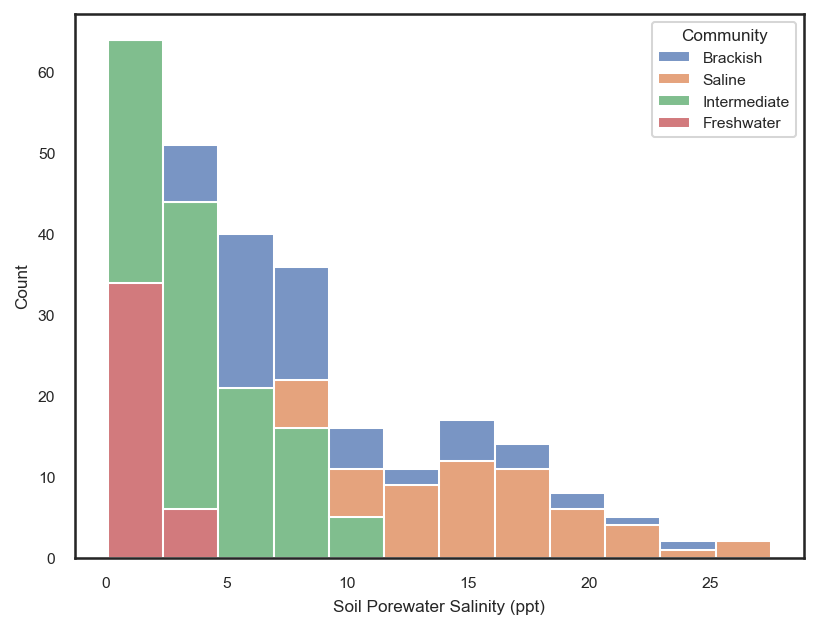

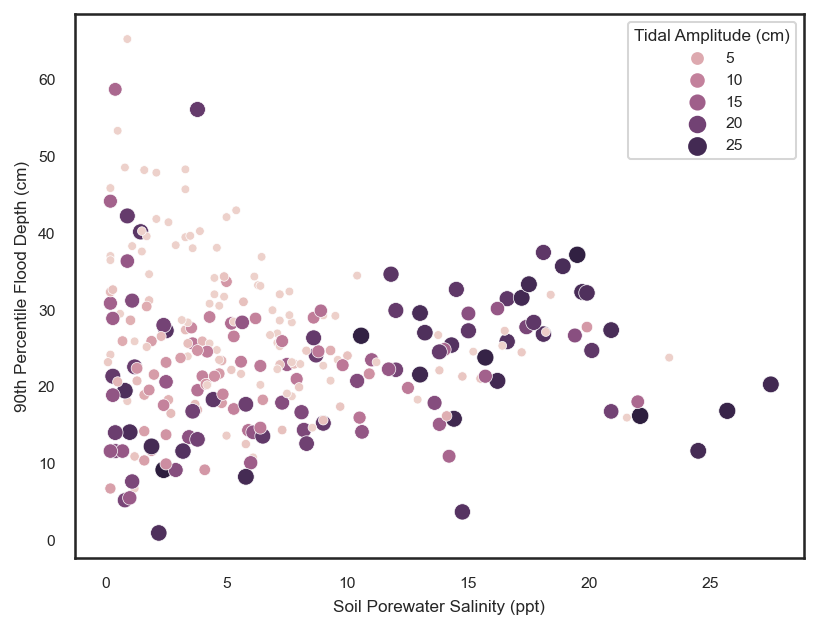

In [32]:
# Histogram to see splits in salinity distributions across marsh types
sns.histplot(data=df, x='Soil Porewater Salinity (ppt)', hue='Community', multiple='stack')
plt.show()
# scatter
sns.scatterplot(data=df, x='Soil Porewater Salinity (ppt)', y='90th Percentile Flood Depth (cm)', hue='Tidal Amplitude (cm)',
               size='Tidal Amplitude (cm)')
plt.show()

The stacked histogram shows us that the distribution of salinity values in the saline marsh sites deviate from the fresher water sites around a value of ~10 ppt. By examining the subsequent scatter plot, we see that above salinity values of ~10 ppt, in the saline marshes, there is a positive trend between salinity and flood depth. While, for salinity values less than ~10 ppt, there is no relationship to a weak logarithmic relationship between flood depth and salinity. This could be potentially highlighting the difference in flooding regimes between the saline sites and the fresher water sites. Great! We have justed used a post-training machine learning explanation technique to find a relationship that we may not have noticed before!

Now let's take a look at both the average flood depth and the 90th percentile of the flood depth

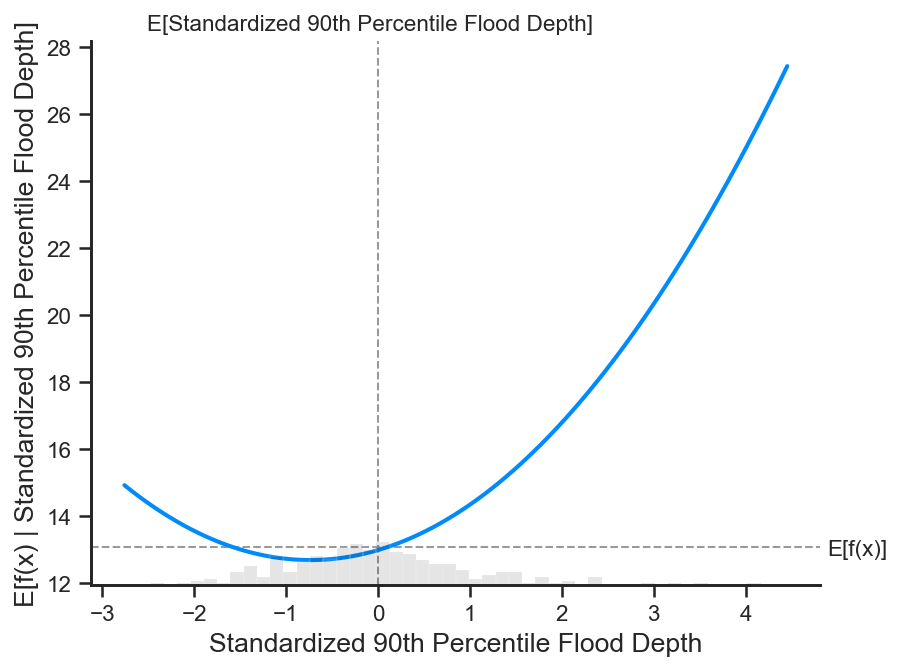

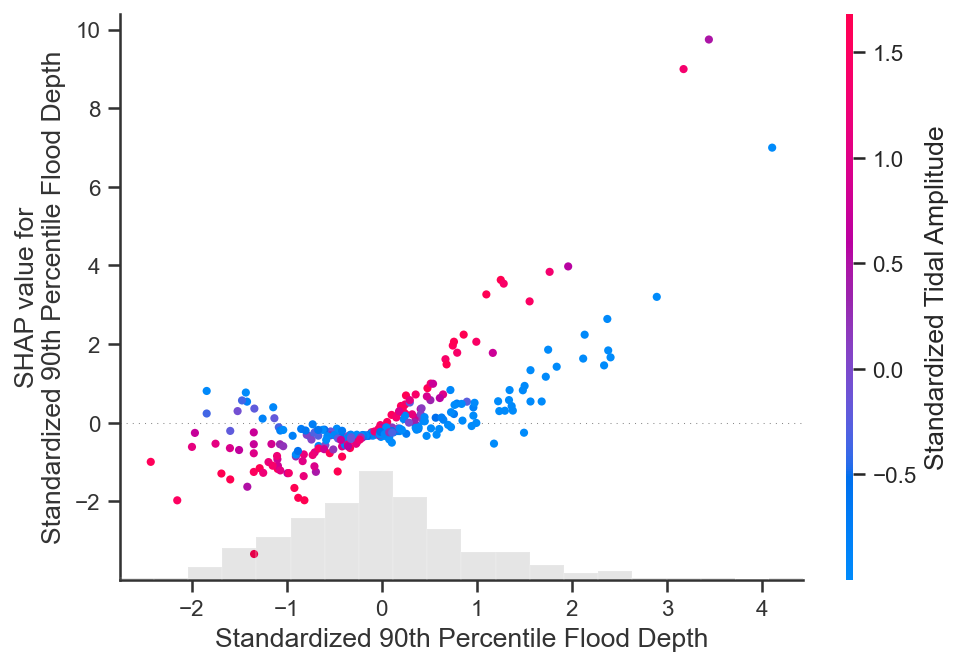

In [33]:
# partial dependence plot for 90th percentile flood depth
shap.partial_dependence_plot(
    'Standardized 90th Percentile Flood Depth', gp.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)
# Now lets look at the dependence plot with interactions
shap.plots.scatter(shap_values_ebm[:, "Standardized 90th Percentile Flood Depth"], 
                   color=shap_values_ebm[:,"Standardized Tidal Amplitude"])

Again, we see the varying influences of the 90th percentile flood depth at different tidal amplitudes. A clear split in the SHAP dependence functions is present between low and high tidal amplitude values. 

Using machine learning techniques not only provides opportunities for increasing the accuracy of forecasts, but also augments our ability to better understand the phenomena we are trying to model through explainable AI. The workflow promoted in this tutorial can be generalized to any earth science application with a small dataset and the goal of obtaining a process based understanding of the influences of the features on the outcome variable. 